# Final modification 
## change the unit of Hv
## operations set without exp, log.. add ^3,1/x..
### second featrues space: with only 2 or 3 parameters

In [1]:
import os
import pandas as pd
import numpy as np
from itertools import combinations
from time import time
import matplotlib.pyplot as plt 
import scipy.stats as ss
import warnings
from collections import Counter
from sklearn.kernel_ridge import KernelRidge
from IPython.display import HTML
from jupyter_jsmol import JsmolView
import itertools
import functools
import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import combine_features as cf
warnings.filterwarnings('ignore')
pd.set_option('mode.use_inf_as_na', True)

In [2]:
print (os.path.abspath('.'))

/Users/zy/Desktop/lasso+l0_abrasion_FV


In [3]:
df = pd.read_csv("groupA.csv")
df.head()
ColNames = df.columns
print(ColNames)
df.head()

Index(['Sample No.', 'Hv\n(kg/mm2)', 'UTS\n(MPa)', 'YS\n(MPa)', 'UE\n(%)',
       'ETF\n(104 Pa)', 'K (MPa)', 'n', 'WL(g)'],
      dtype='object')


,Sample No.,Hv (kg/mm2),UTS (MPa),YS (MPa),UE (%),ETF (104 Pa),K (MPa),n,WL(g)
0,A1,178,515,311,16.40,15292,1034,0.26,0.7889
1,A2,311,839,456,8.25,9554,2080,0.28,0.6847
2,A3,367,949,486,5.95,6137,3386,0.36,0.6257
3,A4,399,1147,612,5.65,7747,3929,0.34,0.5757
4,A5,426,1226,683,5.20,10370,3901,0.33,0.6072


In [4]:
df.rename(columns={'ETF\n(104 Pa)':'ETF(MPa)'},inplace=True)
df['ETF(MPa)']=df['ETF(MPa)']/100 # 把etf的单位变为mpa
df.columns=['Sample No.','Hv','UTS','YS','UE','ETF','K','n','WL']
df['UE']=df['UE']/100 # 把ue变成小数
df['Hv']=df['Hv']*9.8  #change the unit of Hv into MPa
#df.to_excel("/Users/zy/Desktop/lasso+l0_abrasion_FV/GA_data.xls", index=False)
df.head()

,Sample No.,Hv,UTS,YS,UE,ETF,K,n,WL
0,A1,1744.4,515,311,0.1640,152.92,1034,0.26,0.7889
1,A2,3047.8,839,456,0.0825,95.54,2080,0.28,0.6847
2,A3,3596.6,949,486,0.0595,61.37,3386,0.36,0.6257
3,A4,3910.2,1147,612,0.0565,77.47,3929,0.34,0.5757
4,A5,4174.8,1226,683,0.0520,103.70,3901,0.33,0.6072


In [5]:
df.drop(['Sample No.'],axis=1,inplace=True)

df.head()

,Hv,UTS,YS,UE,ETF,K,n,WL
0,1744.4,515,311,0.1640,152.92,1034,0.26,0.7889
1,3047.8,839,456,0.0825,95.54,2080,0.28,0.6847
2,3596.6,949,486,0.0595,61.37,3386,0.36,0.6257
3,3910.2,1147,612,0.0565,77.47,3929,0.34,0.5757
4,4174.8,1226,683,0.0520,103.70,3901,0.33,0.6072


一、定义operations set{+,-,*,/,^2}

In [6]:
##二元函数
_my_sum = lambda x:np.sum(x)
_my_diff= lambda x:np.diff(x)
_my_abs_diff= lambda x:np.abs(_my_diff(x))

_my_power_2=lambda x: np.power(x,2)
#_my_power_3=lambda x: x**3


def _my_div(x):
    return x[0]/x[1]
_my_mul= lambda x:np.prod(x)

In [7]:


##一元函数
# _my_exp=lambda x: np.exp(x)
# _my_log= lambda x : math.log(x)
def _my_power_n(x):
    
    a=np.power(x,df['n'])
    a.astype(np.int)
    #print(a.dtype)
    return a
def _my_sum_power_2(x):
    return np.square(_my_sum(x))
def _my_diff_power_2(x):
    return np.square(_my_diff(x))





In [8]:
def combine_features(df=None, allowed_operations=None, is_print=True):
### generate combinatons of features by given a dataframe and a list of allowed operations.
    if is_print:
        if allowed_operations:
            print('Selected operations:\\n {0}'.format(allowed_operations))
        else:
            print('No allowed operations selected.')
        columns_ = df.columns.tolist()
    dict_features={
        ## 变量分类
        'UTS':'a1',
        'YS':'a1',
        'ETF':'a1',
        'K':'a1',
        'Hv':'a1', 
        
        'UE':'a2',
        'n':'a2',
    
        }
    df_a1 = df[[col for col in columns_ if dict_features.get(col.split('(', 1)[0])=='a1']].astype('float32')
    df_a2 = df[[col for col in columns_ if dict_features.get(col.split('(', 1)[0])=='a2']].astype('float32')
  
    col_a1 = df_a1.columns.tolist()
    col_a2 = df_a2.columns.tolist()

    ## this list will at the end all the dataframes created\n',
    df_list = []
    
    df_b1_list = []
    df_b2_list = []
    df_c1_list = []
    df_c2_list = []
    df_d1_list = []
    df_d2_list = []
    df_e_list = []
    df_f_list = []
    df_g_list = []

    
    df_x1_list = []
    df_x2_list = []
    df_y1_list = []
    df_y2_list = []
    df_z_list = []

    # create b1: absolute differences and sums of a1
    for subset in itertools.combinations(col_a1,2):
        if '+' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')']
            data = df_a1[list(subset)].apply(_my_sum,axis=1)
            df_b1_list.append(pd.DataFrame(data,columns=cols))
            
#         if '-' in allowed_operations:
#             cols = ['('+subset[1]+'-'+subset[0]+')']
#             data = df_a1[list(subset)].apply(_my_diff,axis=1)
#             df_b1_list.append(pd.DataFrame(data,columns=cols))
            
        if '|-|' in allowed_operations:
            cols = ['|'+subset[1]+'-'+subset[0]+'|']
            data = df_a1[list(subset)].apply(_my_abs_diff,axis=1)
            df_b1_list.append(pd.DataFrame(data,columns=cols))
            
                   
    #create b2: abs diff and sums of a2:
    for subset in itertools.combinations(col_a2,2):
        if '+' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')']
            data = df_a2[list(subset)].apply(_my_sum,axis=1)
            df_b2_list.append(pd.DataFrame(data,columns=cols))

            
#         if '-' in allowed_operations:
#             cols = ['('+subset[1]+'-'+subset[0]+')']
#             data = df_a2[list(subset)].apply(_my_diff,axis=1)
#             df_b2_list.append(pd.DataFrame(data,columns=cols))

            
        if '|-|' in allowed_operations:
            cols = ['|'+subset[1]+'-'+subset[0]+'|']
            data = df_a2[list(subset)].apply(_my_abs_diff,axis=1)
            df_b2_list.append(pd.DataFrame(data,columns=cols))
            
    # create c1:^2 of a1:
    for subset in itertools.combinations(col_a1,1):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'^2'+')']       
            f = df_a1[list(subset)].apply(_my_power_2,axis=1)
            data=f.values
            df_c1_list.append(pd.DataFrame(data,columns=cols))
#         if '^3' in allowed_operations:
#             cols = ['('+subset[0]+'^3'+')']       
#             f = df_a1[list(subset)].apply(_my_power_3,axis=1)
#             data=f.values
#             df_c1_list.append(pd.DataFrame(data,columns=cols))
            
    # create c2:^2 of a2:
    for subset in itertools.combinations(col_a2,1):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'^2'+')']       
            f = df_a2[list(subset)].apply(_my_power_2,axis=1)
            data=f.values
            df_c2_list.append(pd.DataFrame(data,columns=cols))
#         if '^3' in allowed_operations:
#             cols = ['('+subset[0]+'^3'+')']       
#             f = df_a2[list(subset)].apply(_my_power_3,axis=1)
#             data=f.values
#             df_c2_list.append(pd.DataFrame(data,columns=cols))

    # create d1:^2 of b1:               
    for subset in itertools.combinations(col_a1, 2):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')'+'^2']       
            f = df_a1[list(subset)].apply(_my_sum_power_2,axis=1)
            data=f.values
            df_d1_list.append(pd.DataFrame(data,columns=cols))
            cols = ['('+subset[0]+'-'+subset[1]+')'+'^2']       
            f = df_a1[list(subset)].apply(_my_diff_power_2,axis=1)
            data=f.values
            df_d1_list.append(pd.DataFrame(data,columns=cols))
       
    # create d2:^2 of b2:
    for subset in itertools.combinations(col_a2, 2):

        if '^2' in allowed_operations:
            cols = ['('+subset[0]+'+'+subset[1]+')'+'^2']       
            f = df_a2[list(subset)].apply(_my_sum_power_2,axis=1)
            data=f.values
            df_d2_list.append(pd.DataFrame(data,columns=cols))
            cols = ['('+subset[0]+'-'+subset[1]+')'+'^2']       
            f = df_a2[list(subset)].apply(_my_diff_power_2,axis=1)
            data=f.values
            df_d2_list.append(pd.DataFrame(data,columns=cols))
            

             
        
    if not df_a1.empty: 
        df_x1_list.append(df_a1)
        df_y1_list.append(df_a1)
        #df_z_list.append(df_a1)
        df_list.append(df_a1)
        
    if not df_a2.empty: 
        df_x1_list.append(df_a2)
        df_y1_list.append(df_a2)
        #df_z_list.append(df_a2)
        df_list.append(df_a2)

        
    if df_b1_list: 
        df_b1 = pd.concat(df_b1_list, axis=1)
        col_b1 = df_b1.columns.tolist()
        df_x1_list.append(df_b1)
        df_list.append(df_b1)

    if df_b2_list: 
        df_b2 = pd.concat(df_b2_list, axis=1)
        col_b2 = df_b2.columns.tolist()
        df_x1_list.append(df_b2)
        df_list.append(df_b2)
        
    if df_c1_list: 
        df_c1 = pd.concat(df_c1_list, axis=1)
        col_c1 = df_c1.columns.tolist()
        df_x1_list.append(df_c1)
        df_y1_list.append(df_c1)
        #df_z_list.append(df_c1)
        df_list.append(df_c1)
    if df_c2_list: 
        df_c2 = pd.concat(df_c2_list, axis=1)
        col_c2 = df_c2.columns.tolist()
        df_x1_list.append(df_c2)
        df_y1_list.append(df_c2)
        #df_z_list.append(df_c2)
        df_list.append(df_c2)
    if df_d1_list: 
        df_d1 = pd.concat(df_d1_list, axis=1)
        col_d1 = df_d1.columns.tolist()
        df_x1_list.append(df_d1)
        df_list.append(df_d1)
    if df_d2_list: 
        df_d2 = pd.concat(df_d2_list, axis=1)
        col_d2 = df_d2.columns.tolist()
        df_x1_list.append(df_d2)
        df_list.append(df_d2)
        
    if df_x1_list:
        df_x1 = pd.concat(df_x1_list, axis=1)
        col_x1 = df_x1.columns.tolist()
        
    if df_x2_list:
        df_x2 = pd.concat(df_x2_list, axis=1)
        col_x2 = df_x2.columns.tolist()
        
        
    if df_y1_list:
        df_y1 = pd.concat(df_y1_list, axis=1)
        col_y1 = df_y1.columns.tolist()
        
    if df_y2_list:
        df_y2 = pd.concat(df_y2_list, axis=1)
        col_y2 = df_y2.columns.tolist()
    if df_z_list:
        df_z = pd.concat(df_z_list, axis=1)
        col_z = df_z.columns.tolist()
        
    #create e: mul within X1:
    for subset in itertools.combinations(col_x1,2):
                if '*' in allowed_operations:
                    #print(subset[0],subset[1])
                    cols = [subset[0]+'*'+subset[1]] 
                    #now the operation is between two dataframes\n',
                    data = df_x1[list(subset)].apply(_my_mul, axis=1)  
                    df_e_list.append(pd.DataFrame(data, columns=cols)) 

                if '/' in allowed_operations:
                    cols = [subset[0]+'/'+subset[1]] 
                    #now the operation is between two dataframes\n',
                    data = df_x1[list(subset)].apply(_my_div, axis=1) 
                    df_e_list.append(pd.DataFrame(data, columns=cols)) 
                    #reverse
                    cols = [subset[1]+'/'+subset[0]] 
                    data = df_x1[list(subset)].apply(_my_div, axis=1) 
                    df_e_list.append(pd.DataFrame(data, columns=cols)) 
    if df_e_list:
        df_e = pd.concat(df_e_list, axis=1)
        col_e = df_e.columns.tolist()
                    
    #create f: mul and ratios of x1 with {a1, a2, c1, c2}:
    if df_y1_list and df_e_list:    
        for sub_y1 in col_y1:
            for sub_e in col_e:
                #print(sub_y1)
                #print(sub_e)
                if '*' in allowed_operations:
                    cols = [sub_y1+'*'+'('+sub_e+')'] 
                    #now the operation is between two dataframes\n',
                    data=df_y1[sub_y1].multiply(df_e[sub_e])
                    df_f_list.append(pd.DataFrame(data, columns=cols)) 
                if '/' in allowed_operations:
                    cols = [sub_y1+'/'+'('+sub_e+')'] 
                    #now the operation is between two dataframes\n',
                    data=df_y1[sub_y1].divide(df_e[sub_e])
                    df_f_list.append(pd.DataFrame(data, columns=cols)) 
                    #reverse
                    cols = ['('+sub_e+')'+'/'+sub_y1] 
                    data=df_e[sub_e].divide(df_y1[sub_y1])
                    df_f_list.append(pd.DataFrame(data, columns=cols)) 
#     if df_f_list:
#         df_f = pd.concat(df_f_list, axis=1)
#         col_f = df_f.columns.tolist()
#     if df_z_list:
#         df_z = pd.concat(df_z_list, axis=1)
#         col_z = df_z.columns.tolist()
#     #print(df_f.info(),df_z.info())
#     #print(df_z)
    
        
#     #create g: mul and ratios of f with {a1, a2, c1, c2}:
#     if df_f_list and df_z_list:    
#         for sub_f in col_f:
#             for sub_z in col_z:
#                 if '*' in allowed_operations:
#                     cols = ['('+sub_f+')'+'*'+'('+sub_z+')'] 
#                     #now the operation is between two dataframes\n',
#                     data=df_f[sub_f].multiply(df_z[sub_z])
#                     df_g_list.append(pd.DataFrame(data, columns=cols)) 
#                 if '/' in allowed_operations:
#                     cols = ['('+sub_f+')'+'/'+'('+sub_z+')'] 
#                     #now the operation is between two dataframes\n',
#                     data=df_f[sub_f].divide(df_z[sub_z])
#                     df_g_list.append(pd.DataFrame(data, columns=cols)) 
#                     #reverse
#                     cols = ['('+sub_z+')'+'/'+'('+sub_f+')'] 
#                     data=df_z[sub_z].divide(df_f[sub_f])
#                     df_g_list.append(pd.DataFrame(data, columns=cols)) 
                    
#     if df_d_list:
#         df_d=pd.concat(df_d_list,axis=1)
#         col_d=df_d.columns.tolist()
#         df_list.append(df_d)
    if df_e_list:
        df_e=pd.concat(df_e_list,axis=1)
        col_e=df_e.columns.tolist()
        df_list.append(df_e)
    if df_f_list:
        df_f=pd.concat(df_f_list,axis=1)
        col_f=df_f.columns.tolist()
        df_list.append(df_f)
#     if df_g_list:
#         df_g=pd.concat(df_g_list,axis=1)
#         col_g=df_g.columns.tolist()
#         df_list.append(df_g)

    if df_list:
        df_combined_features = pd.concat(df_list, axis=1)
        #print(len(df_b1_list),len(df_b2_list),len(df_d_list),len(df_e_list))
    elif is_print:
        print('No features selected. Please select at least two primary features.')


    if is_print:
        print('Number of total features generated: {0}'.format(df_combined_features.shape[1]))

    return df_combined_features 
            

In [9]:
def get_data(selected_feature_list, allowed_operations):
    # extract WEARLOSS and selected features from df_data 
    P = df['WL'].values
    df_features = df[selected_feature_list]
    
    # derive new features using allowed_operations
    df_combined = combine_features(df=df_features, allowed_operations=allowed_operations)
    return P, df_combined

In [10]:
#import Data
selected_feature_list = ['UE','Hv','UTS','YS','n','ETF','K']
allowed_operations = ['+','-','|-|','/','*','^2']



P, df_D = get_data(selected_feature_list, allowed_operations)
print(len(list(df_D)))
df_D.replace([np.inf, -np.inf], np.nan,inplace=True)
df_D =df_D.dropna(axis=1)
df_D = df_D.loc[:, (df_D != 0).any(axis=0)]

print(len(list(df_D)))


D = df_D.values
D = D.astype(np.float64)
features_list = df_D.columns.tolist()
df_D.info()
df_D.isna().values.any()



Selected operations:\n ['+', '-', '|-|', '/', '*', '^2']
Number of total features generated: 213295
213295
213295
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 213295 entries, Hv to ((UE-n)^2/(UE+n)^2)/(n^2)
dtypes: float32(14), float64(81292), object(131989)
memory usage: 32.5+ MB


False

In [25]:
df_D=pd.DataFrame(df_D,dtype=np.float)
df_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 213295 entries, Hv to ((UE-n)^2/(UE+n)^2)/(n^2)
dtypes: float64(213295)
memory usage: 32.5 MB


In [11]:
# pd.set_option('display.width', 10)  # 设置字符显示宽度
# pd.set_option('display.max_rows', None)  # 设置显示最大行
# print(df_D.iloc[0])
# df_D.iloc[0].isnull().values.any()

In [26]:
#standardize data
D_standardized = ss.zscore(D)
print(D_standardized.shape)
print(type(D_standardized))
np.isnan(D_standardized).any()
#print(np.isnan(D_standardized).any(axis=0))
D_standardized=D_standardized[:, ~np.isnan(D_standardized).any(axis=0)]

(20, 213295)
<class 'numpy.ndarray'>


In [13]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, D_standardized, P, 
                                   scoring="neg_mean_squared_error", cv = 5))
    return(rmse)



In [14]:
# ##cv调参2
# # 根据上图建立Lasso进行alpha选择的范围
# alpha_range = np.linspace(0.1,0.001,70)

# # # LassoCV
# lasso_ = LassoCV(alphas=alpha_range,cv=5).fit(D_standardized,P)

# # # 查看最佳正则化系数
# best_alpha = lasso_.alpha_ 
# print(best_alpha)




In [15]:
def rmse():
    
    P_predict = lasso.predict(D_standardized)
    #print(P_predict)
    RMSE_LASSO = np.linalg.norm(P-P_predict) / np.sqrt(20.)
    return RMSE_LASSO




In [16]:
from sklearn.metrics import r2_score
def r_2():
    P_predict = lasso.predict(D_standardized)
    return r2_score(P_predict,P)



In [17]:
# #以线性关系改变lambda的值，观察非零系数的个数
# from sklearn.linear_model import Lasso
# alpha = np.linspace(0.04,0.002,9)
# m=0
# lams=[]
# rmse_s=[]
# #table = PrettyTable(['NO.','alpha', 'num_nonzero','selected features','rmse','coef','r^2','intercept'])


# for i in range(90):
#     global m
#     lasso=Lasso(alpha=alpha[i])
#     lasso.fit(D_standardized,P)
#     coef=lasso.coef_
#     a=np.sum(coef != 0)
    
#     if a!=m:
#         m=a
        
# #         print(m)
# #         print(alpha[i])

        
#     # get strings of selected features
#         selected_indices = lasso.coef_.nonzero()[0]
#         selected_features = [features_list[i] for i in selected_indices]
#         #print(lasso.predict(D_standardized))
#         #print(pd.DataFrame({'alpha':"%.3f" %alpha[i],'num_nonzero':m,'features_list':selected_features,'rmse':rmse_cv(),'coef':coef[coef.nonzero()].round(3)}))
#         #print('alpha',"%.3f" %alpha[i],'num_nonzero',m,selected_features,'rmse',rmse_cv(),'coef',coef[coef.nonzero()].round(5))
#         #pd.Series(index = ['Intercept'] + D_standardized.columns.tolist(),data = [lasso.intercept_] + lasso.coef_.tolist())
#         #print(lasso.intercept_)
#         if a<=10:
#             #table.add_row([i,alpha[i].round(2),m,selected_features,rmse().round(2),coef[coef.nonzero()].round(2),lasso.intercept_.round(2),r_2()])
#             print('alpha',"%.5f" %alpha[i],'num_nonzero',m,selected_features,'rmse',rmse().round(4),'coef',coef[coef.nonzero()].round(5),'截距:',lasso.intercept_.round(2),'\n','r_squared:',r_2().round(5))
            
#             rmse_s.append(rmse)
#             lams.append(alpha[i])



# # print("lambda: %.3f\t dimension of descriptor: %s\t RMSE_LASSO: %.3f\t RMSE_LS: %.3f" 
# #       %(lam, len(selected_features), RMSE_LASSO, RMSE_LS))
# # print(pd.DataFrame({'features':np.array(selected_features), 'abs(nonzero_coefs_LASSO)': np.abs(coef[coef.nonzero()])}))
# # plt.show()  

In [27]:
model=Lasso(0.02575).fit(D_standardized,P)
coef=model.coef_
a=np.sum(coef != 0)
selected_indices = model.coef_.nonzero()[0]
selected_features = [features_list[i] for i in selected_indices]
#print('num_nonzero',a,selected_features,'rmse',rmse(),'coef',coef[coef.nonzero()].round(8),'截距:',model.intercept_)





In [28]:
#print(selected_features)
D_screened=df_D[selected_features]
D_= D_screened.values
D_= D_.astype(np.float64)
D_screened.info()
D_screened_standardized = ss.zscore(D_)
print(len(D_screened_standardized[0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
K/((YS+ETF)^2/(YS-ETF)^2)     20 non-null float64
K/((YS-ETF)^2/(YS+ETF)^2)     20 non-null float64
((Hv+K)*(YS-ETF)^2)/(YS^2)    20 non-null float64
(K^2)/(n*(UTS+ETF))           20 non-null float64
dtypes: float64(4)
memory usage: 720.0 bytes
4


In [20]:
def L0(P, D, dimension):
    n_rows, n_columns = D.shape
    D = np.column_stack((D, np.ones(n_rows)))
    SE_min = np.inner(P ,P)
    coef_min, permu_min = None, None
    for permu in combinations(range(n_columns), dimension):
        D_ls = D[:, permu + (-1,)]
        coef, SE, __1, __2 = np.linalg.lstsq(D_ls, P, rcond=-1)
        try:
            if SE[0] < SE_min: 
                SE_min = SE[0]
                coef_min, permu_min = coef, permu
        except:
            pass
    RMSE = np.sqrt(SE_min/n_rows)
    return RMSE, coef_min, permu_min

In [21]:
def L0_predict(coefficients,X,selected_indices):
    X = np.array(X)
    p=len(X)
    y_pred=[]
    n=len(selected_indices)
    X_selected=np.zeros(shape=((n,p)))
    w=coefficients
    m=len(coefficients)
    print('len(coefs)=',m)

    z=0
    for j in selected_indices:
        #print(X[:,j])
        #np.append(X_selected[z,:],X[:,j],axis=1)
        X_selected[z,:]=X[:,j]
        z=z+1
    #print('X_selected',X_selected) 
    #print('selected indices',n)
    for i in range(0,p):
        #print(i)
#         print('yes')
#         print(X_selected[i])
#         print(X_selected[i]* w[0:n] + w[n])
#         print(w[0:n])
#         print(w[n])

        #ele=w[0:m-1]*X_selected[:,i]+ w[m-1]
        ele=np.dot(w[0:m-1],X_selected[:,i])+w[m-1]
        #print(ele)
        #print(w[0:m-1],X_selected[:,i],w[m-1])
    
        y_pred.append(ele.round(4))
    #print(type(y_pred))
    
    
    return y_pred




In [29]:

print("     RMSE   best desriptor")
for dim in range(1,2):
    RMSE, coefficients, selected_indices_l0 = L0(P,D_screened_standardized,dim)
    print(selected_indices_l0)
    print(selected_features)
    Y_pre=L0_predict(coefficients,D_screened_standardized,selected_indices_l0)
    #print(Y_pre)
    score=r2_score(P,Y_pre)
    descriptor=[selected_features[i] for i in selected_indices_l0]
    print('%2sD: %.5f' % (dim, RMSE), [selected_features[i] for i in selected_indices_l0],coefficients,'score',score)
    df_A_3=df_D[descriptor]
    df_A_3.to_excel("/Users/zy/Desktop/lasso+l0_abrasion_FV/dfA3.xlsx")
    #print('y_pred:',y_pred(coefficients,D,selected_indices))

     RMSE   best desriptor
(0,)
['K/((YS+ETF)^2/(YS-ETF)^2)', 'K/((YS-ETF)^2/(YS+ETF)^2)', '((Hv+K)*(YS-ETF)^2)/(YS^2)', '(K^2)/(n*(UTS+ETF))']
len(coefs)= 2
 1D: 0.02186 ['K/((YS+ETF)^2/(YS-ETF)^2)'] [-0.07744828  0.66381   ] score 0.9262244811568677


In [23]:

print("     RMSE   best desriptor")
for dim in range(1,2):
    RMSE, coefficients, selected_indices = L0(P,D_standardized,dim)
    #print(selected_indices)
    Y_pre=L0_predict(coefficients,D_standardized,selected_indices)
    print(Y_pre)
    score=r2_score(P,Y_pre)
    descriptor=[selected_features[i] for i in selected_indices_l0]
    print('%2sD: %.5f' % (dim, RMSE), [features_list[i] for i in selected_indices],coefficients,'score',score)
    #print('y_pred:',y_pred(coefficients,D,selected_indices))

     RMSE   best desriptor
len(coefs)= 2
[0.7829, 0.7182, 0.6214, 0.5941, 0.6149, 0.7746, 0.6982, 0.612, 0.5733, 0.5706, 0.7676, 0.7335, 0.6947, 0.6771, 0.6816, 0.4827, 0.6092, 0.6429, 0.6774, 0.7492]
 1D: 0.02186 ['K/((YS+ETF)^2/(YS-ETF)^2)'] [-0.07744828  0.66381   ] score 0.9262244811568677


In [24]:
df_A= pd.read_csv('/Users/zy/Desktop/sisso_abraision_version0/dfA_22.csv')


df_A[descriptor] = df_D[descriptor]

df_A.to_csv('/Users/zy/Desktop/sisso_abraision_version0/dfA_22.csv',index=False)

In [25]:
print(df_D[descriptor])

   K/((YS+ETF)^2/(YS-ETF)^2)
0                [120.05721]
1                [888.43054]
2                [2037.7286]
3                [2361.5413]
4                [2115.2644]
5                 [218.8126]
6                [1126.5222]
7                [2149.2432]
8                [2608.4744]
9                 [2640.618]
10               [302.35654]
11                [706.9053]
12                [1168.148]
13               [1376.7565]
14               [1323.7632]
15               [3683.7573]
16                [2182.189]
17               [1782.9502]
18               [1372.9364]
19                [520.8927]


len(coefs)= 2
r^2= 0.9262244811568677


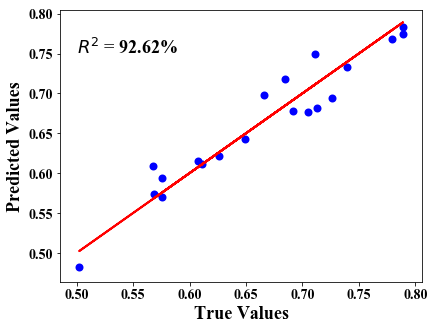

r^2= 0.9262244811568677


In [38]:
plt.rc('font',family='Times New Roman')  #定义字体

plt.figure(figsize=(6.5,5))    #设置图片大小

font1 = {'family' : 'Times New Roman',

'weight' : 'normal',

'size'   : 18,

}




plt.xticks(fontsize=14)       #设置坐标轴刻度字号

plt.yticks(fontsize=14)

x=df['WL']
true_values = np.array(x)

Y_pre=L0_predict(coefficients,D_screened_standardized,selected_indices_l0)
predicted_values=np.array(Y_pre)
y=x
plt.plot(x,y,linewidth=2,color='r')    #画图，第一条线，线宽为2,颜色用color设置
plt.scatter(true_values,predicted_values, linewidth=2,color='b')

# plt.plot(x,y,c='red')




# plt.plot(x,Y2,'-.',linewidth=2)

# plt.plot(x,Y3,'--',linewidth=2)

# plt.plot(x,Y4,':',linewidth=2)

# plt.plot(x,Y5,dashes=[8, 3],linewidth=2) #画图，第五条线，线型通过[8,3]修改

# plt.ylim(-0.001,0.01)                     #纵坐标范围

# plt.xlim(0,0.65)                          #横坐标范围

# plt.title('R',font1) #标题

plt.xlabel("True Values",font1)          #x轴名称

plt.ylabel("Predicted Values",font1)    #y轴名称

# plt.legend([r"$\beta_i=0$",r"$\beta_i=0.025$",r"$\beta_i=0.05$",r"$\beta_i=0.075$",r"$\beta_i=0.1$"],fontsize=14,edgecolor="black") #设置标注

# foo_fig=plt.gcf()

# foo_fig.savefig('figure1.eps',format='eps',dpi=1000)  #存储为eps格式，分辨率100dpi
print('r^2=',r2_score(true_values,predicted_values))


plt.text(0.5,0.75,r'$R^{2}$ = 92.62%',fontdict={'size':'18','color':'black'})
#保存图片，在plt.show()前进行
#plt.savefig("/Users/zy/Desktop/sisso_abraision_version0/GA_multi-factor2.png", format='png',dpi=300,bbox_inches='tight')

plt.show()
print('r^2=',r2_score(true_values,predicted_values))





r^2= 0.9261843714927732


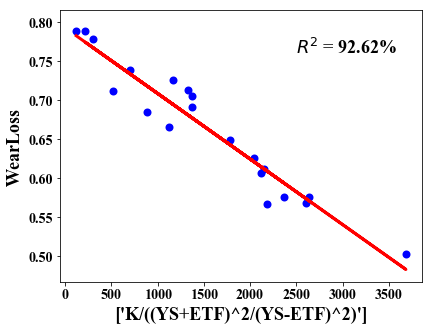

In [39]:
from sklearn.linear_model import LinearRegression


plt.rc('font',family='Times New Roman')  #定义字体

plt.figure(figsize=(6.5,5))    #设置图片大小

font1 = {'family' : 'Times New Roman',

'weight' : 'normal',

'size'   : 18,

}




plt.xticks(fontsize=14)       #设置坐标轴刻度字号

plt.yticks(fontsize=14)

x=df_D[descriptor]
plt.scatter(x,P, linewidth=2,color='b')

x_=x.values.reshape(-1,1)
model=LinearRegression()

model.fit(x_,y)
y_pred=model.predict(x_)


plt.plot(x_,y_pred,color='red',linewidth=3,label='best line')

print('r^2=',model.score(x_,y))

# plt.plot(x,y,c='red')




# plt.plot(x,Y2,'-.',linewidth=2)

# plt.plot(x,Y3,'--',linewidth=2)

# plt.plot(x,Y4,':',linewidth=2)

# plt.plot(x,Y5,dashes=[8, 3],linewidth=2) #画图，第五条线，线型通过[8,3]修改

# plt.ylim(-0.001,0.01)                     #纵坐标范围

# plt.xlim(0,0.65)                          #横坐标范围

# plt.title('R',font1) #标题

plt.xlabel(descriptor,font1)          #x轴名称

plt.ylabel("WearLoss",font1)    #y轴名称

# plt.legend([r"$\beta_i=0$",r"$\beta_i=0.025$",r"$\beta_i=0.05$",r"$\beta_i=0.075$",r"$\beta_i=0.1$"],fontsize=14,edgecolor="black") #设置标注

# foo_fig=plt.gcf()

# foo_fig.savefig('figure1.eps',format='eps',dpi=1000)  #存储为eps格式，分辨率100dpi
#print('r^2=',r2_score(true_values,predicted_values))


plt.text(2500,0.76,r'$R^{2}$ = 92.62%',fontdict={'size':'18','color':'black'})
#保存图片，在plt.show()前进行
plt.savefig("/Users/zy/Desktop/sisso_abraision_version0/D3_A.png", format='png',dpi=300,bbox_inches='tight')

plt.show()
#print('r^2=',r2_score(true_values,predicted_values))








